# Time Series

## Importing Module

In [1]:
import os
import csv
import urllib

import pandas as pd
import numpy as np
import tensorflow as tf

from matplotlib import pyplot as plt

%matplotlib inline
plt.style.use('seaborn')
print(f'Tensorflow version: {tf.__version__}')

Tensorflow version: 2.8.2


## PROBLEM A5

- Build and train a neural network model using the Sunspots.csv dataset.
- Use MAE as the metrics of your neural network model.
- We provided code for normalizing the data. Please do not change the code.
- Do not use lambda layers in your model.
- The dataset used in this problem is downloaded from kaggle.com/robervalt/sunspots
- Desired `MAE` < `0.15` on the normalized dataset.

### Prepare Data

In [2]:
data_url = 'https://github.com/dicodingacademy/assets/raw/main/Simulation/machine_learning/sunspots.csv'
name_file = 'sunspots.csv'

if os.path.isfile(name_file) == False:
  urllib.request.urlretrieve(data_url, name_file)
  print(f'{name_file} Downloaded')
else:
  print(f'{name_file} Already exist')

sunspots.csv Downloaded


### Analysis Data with Pandas

In [3]:
df = pd.read_csv(name_file, index_col=0)
df.head()

,Date,Monthly Mean Total Sunspot Number
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [4]:
df.columns = ['date', 'monthly_mean']

In [5]:
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3265 entries, 0 to 3264
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          3265 non-null   datetime64[ns]
 1   monthly_mean  3265 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 76.5 KB


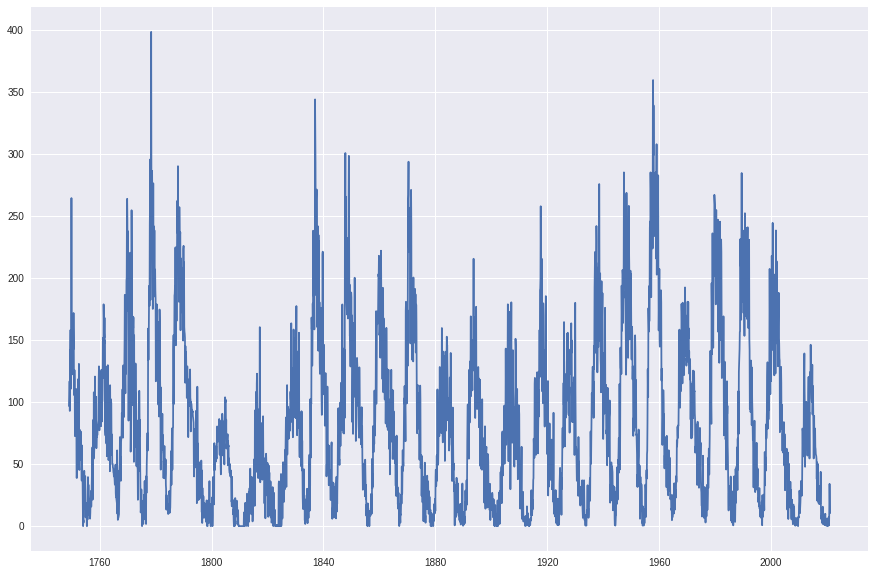

In [6]:
plt.figure(figsize=(15,10))
plt.plot(df['date'], df['monthly_mean'])
plt.show()

### Open with Csv module

In [7]:
time_step = []
sunspots = []

with open(name_file, 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)

### Normalization Data

In [8]:
min = np.min(series)
max = np.max(series)
series -= min
series /= max

### Set Params

In [9]:
split_time = 3000

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

desired_accuracy = 0.15

### Fixed Partition

In [10]:
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Windowing Datasets

In [11]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [12]:
train_set=windowed_dataset(x_train, window_size=window_size,
                               batch_size=batch_size, shuffle_buffer=shuffle_buffer_size)

### Create Custom Callbacks

In [13]:
class MyCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epochs, logs):
            if logs.get('mae') < desired_accuracy:
                print(f'\nTraining MAE was < {desired_accuracy*100}%, stop training...')
                self.model.stop_training = True

custom_callback = MyCallback()

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 20))

### Create Model with Learning rate Schedule

In [14]:
def create_model():
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]))
  model.add(tf.keras.layers.LSTM(64, return_sequences=True))
  model.add(tf.keras.layers.LSTM(64, return_sequences=True))
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(1))

  model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=1e-7),
        loss=tf.keras.losses.Huber(),
        metrics=["mae"])
  
  return model

In [15]:
model = create_model()
print(f"Model : {model}")

Model : <keras.engine.sequential.Sequential object at 0x7f246e16f3d0>


In [16]:
hist = model.fit(train_set ,epochs=100, callbacks=[lr_schedule])

Epoch 1/100
93/93 [==============================] - 21s 14ms/step - loss: 0.0388 - mae: 0.2155 - lr: 1.0000e-07
Epoch 2/100
93/93 [==============================] - 1s 10ms/step - loss: 0.0388 - mae: 0.2153 - lr: 1.1220e-07
Epoch 3/100
93/93 [==============================] - 1s 10ms/step - loss: 0.0387 - mae: 0.2152 - lr: 1.2589e-07
Epoch 4/100
93/93 [==============================] - 1s 10ms/step - loss: 0.0387 - mae: 0.2150 - lr: 1.4125e-07
Epoch 5/100
93/93 [==============================] - 1s 10ms/step - loss: 0.0386 - mae: 0.2148 - lr: 1.5849e-07
Epoch 6/100
93/93 [==============================] - 1s 10ms/step - loss: 0.0386 - mae: 0.2145 - lr: 1.7783e-07
Epoch 7/100
93/93 [==============================] - 1s 10ms/step - loss: 0.0385 - mae: 0.2142 - lr: 1.9953e-07
Epoch 8/100
93/93 [==============================] - 1s 10ms/step - loss: 0.0384 - mae: 0.2140 - lr: 2.2387e-07
Epoch 9/100
93/93 [==============================] - 1s 10ms/step - loss: 0.0383 - mae: 0.2136 - lr: 2.

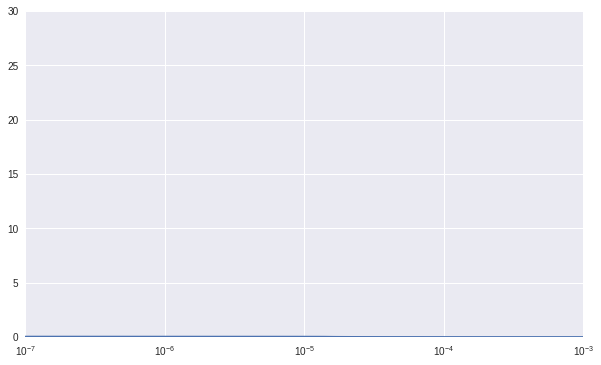

In [17]:
plt.figure(figsize=(10,6))
plt.semilogx(hist.history["lr"], hist.history["loss"])
plt.axis([1e-7, 1e-3, 0, 30])
plt.show()

### Create fixed model

In [18]:
def create_model_fix():
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]))
  model.add(tf.keras.layers.LSTM(64, return_sequences=True))
  model.add(tf.keras.layers.LSTM(64, return_sequences=True))
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(1))

  model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=1e-1),
        loss=tf.keras.losses.Huber(),
        metrics=["mae"])
  
  return model

In [19]:
model = create_model_fix()
print(f"Model : {model}")

Model : <keras.engine.sequential.Sequential object at 0x7f2467448d50>


In [20]:
hist = model.fit(train_set ,epochs=100, callbacks=[custom_callback])

Epoch 1/100
93/93 [==============================] - 5s 11ms/step - loss: 0.0494 - mae: 0.1955
Epoch 2/100
90/93 [============================>.] - ETA: 0s - loss: 0.0150 - mae: 0.1406
Training MAE was < 15.0%, stop training...
93/93 [==============================] - 1s 10ms/step - loss: 0.0150 - mae: 0.1406


# PROBLEM B5
- Build and train a neural network model using the Daily Max Temperature.csv dataset.
- Use MAE as the metrics of your neural network model.
- We provided code for normalizing the data. Please do not change the code.
- Do not use lambda layers in your model.
- The dataset used in this problem is downloaded from https://github.com/jbrownlee/Datasets
- Desired `MAE < 0.2` on the normalized dataset.

### Prepare Data

In [21]:
data_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-max-temperatures.csv'
name_file = 'daily-max-temperatures.csv'

if os.path.isfile(name_file) == False:
  urllib.request.urlretrieve(data_url, name_file)
  print(f'{name_file} Downloaded')
else:
  print(f'{name_file} Already exist')

daily-max-temperatures.csv Downloaded


### Analysis Data with Pandas

In [22]:
df = pd.read_csv(name_file)
df.head()

,Date,Temperature
0,1981-01-01,38.1
1,1981-01-02,32.4
2,1981-01-03,34.5
3,1981-01-04,20.7
4,1981-01-05,21.5


In [23]:
df.columns = ['date', 'temperature']

In [24]:
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         3650 non-null   datetime64[ns]
 1   temperature  3650 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB


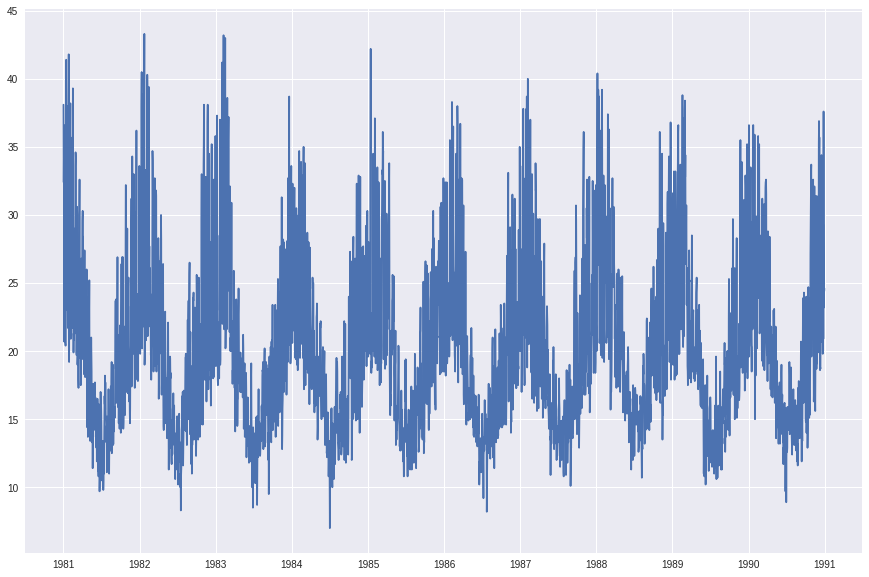

In [25]:
plt.figure(figsize=(15,10))
plt.plot(df['date'], df['temperature'])
plt.show()

### Open with Csv module

In [26]:
time_step = []
temps = []

with open(name_file, 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step = 0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step +=1

series = np.array(temps)
time = np.array(time_step)

In [27]:
len(series)

3650

### Normalization Function

In [28]:
# DO NOT CHANGE THIS CODE
min=np.min(series)
max=np.max(series)
series -= min
series /= max

### Set Params

In [29]:
# DO NOT CHANGE THIS CODE
window_size=64
batch_size=256
shuffle_buffer_size=1000

split_time=2500

desired_accuracy = 0.2

### Fixed Partition

In [30]:
time_train= time[:split_time]
x_train= series[:split_time]
time_valid= time[split_time:]
x_valid= series[split_time:]

### Windowing Datasets

In [31]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)


In [32]:
train_set=windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(2500,)


### Create Custom Callbacks

In [33]:
class MyCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epochs, logs):
            if logs.get('mae') < desired_accuracy:
                print(f'\nTraining MAE was < {desired_accuracy*100}%, stop training...')
                self.model.stop_training = True

custom_callback = MyCallback()

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 20))

### Create Model with Learning rate Schedule

In [34]:
def create_model():
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]))
  model.add(tf.keras.layers.LSTM(64, return_sequences=True))
  model.add(tf.keras.layers.LSTM(64, return_sequences=True))
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(1))

  model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=1e-7),
        loss=tf.keras.losses.Huber(),
        metrics=["mae"])
  
  return model

In [35]:
model = create_model()
print(f"Model : {model}")

Model : <keras.engine.sequential.Sequential object at 0x7f2467dc4c50>


In [36]:
hist = model.fit(train_set ,epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 5s 45ms/step - loss: 0.0514 - mae: 0.2892 - lr: 1.0000e-07
Epoch 2/100
10/10 [==============================] - 0s 28ms/step - loss: 0.0514 - mae: 0.2891 - lr: 1.1220e-07
Epoch 3/100
10/10 [==============================] - 0s 29ms/step - loss: 0.0514 - mae: 0.2891 - lr: 1.2589e-07
Epoch 4/100
10/10 [==============================] - 0s 30ms/step - loss: 0.0514 - mae: 0.2890 - lr: 1.4125e-07
Epoch 5/100
10/10 [==============================] - 0s 32ms/step - loss: 0.0513 - mae: 0.2890 - lr: 1.5849e-07
Epoch 6/100
10/10 [==============================] - 0s 31ms/step - loss: 0.0513 - mae: 0.2889 - lr: 1.7783e-07
Epoch 7/100
10/10 [==============================] - 0s 30ms/step - loss: 0.0513 - mae: 0.2888 - lr: 1.9953e-07
Epoch 8/100
10/10 [==============================] - 0s 29ms/step - loss: 0.0513 - mae: 0.2887 - lr: 2.2387e-07
Epoch 9/100
10/10 [==============================] - 0s 29ms/step - loss: 0.0512 - mae: 0.2886 - lr: 2.5

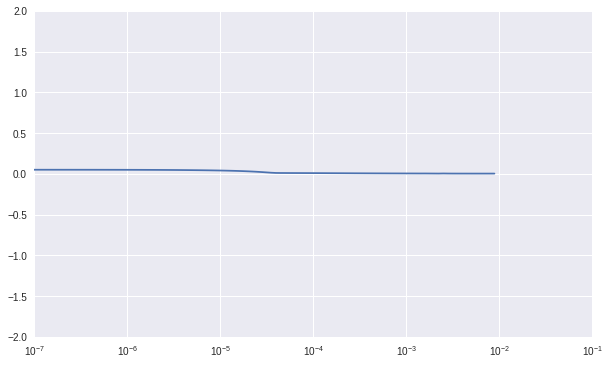

In [37]:
plt.figure(figsize=(10,6))
plt.semilogx(hist.history["lr"], hist.history["loss"])
plt.axis([1e-7, 1e-1, -2, 2])
plt.show()

### Create fixed model

In [38]:
def create_model_fix():
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]))
  model.add(tf.keras.layers.LSTM(64, return_sequences=True))
  model.add(tf.keras.layers.LSTM(64, return_sequences=True))
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(1))

  model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=1e-1),
        loss=tf.keras.losses.Huber(),
        metrics=["mae"])
  
  return model

In [39]:
model = create_model_fix()
print(f"Model : {model}")

Model : <keras.engine.sequential.Sequential object at 0x7f2455345390>


In [40]:
hist = model.fit(train_set ,epochs=100, callbacks=[custom_callback])

Epoch 1/100
10/10 [==============================] - 4s 25ms/step - loss: 0.3762 - mae: 0.6446
Epoch 2/100
 8/10 [=======================>......] - ETA: 0s - loss: 0.0199 - mae: 0.1535
Training MAE was < 20.0%, stop training...
10/10 [==============================] - 0s 31ms/step - loss: 0.0185 - mae: 0.1470


# PROBLEM C5

- Build and train a neural network model using the Daily Min Temperature.csv dataset.
- Use MAE as the metrics of your neural network model.
- We provided code for normalizing the data. Please do not change the code.
- Do not use lambda layers in your model.

- The dataset used in this problem is downloaded from https://github.com/jbrownlee/Datasets

- Desired `MAE < 0.19` on the normalized dataset.

### Prepare Data

In [41]:
data_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv'
name_file = 'daily-min-temperatures.csv'

if os.path.isfile(name_file) == False:
  urllib.request.urlretrieve(data_url, name_file)
  print(f'{name_file} Downloaded')
else:
  print(f'{name_file} Already exist')

daily-min-temperatures.csv Downloaded


### Analysis Data with Pandas

In [42]:
df = pd.read_csv(name_file)
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [43]:
df.columns = ['date', 'temperature']

In [44]:
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650 entries, 0 to 3649
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         3650 non-null   datetime64[ns]
 1   temperature  3650 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 57.2 KB


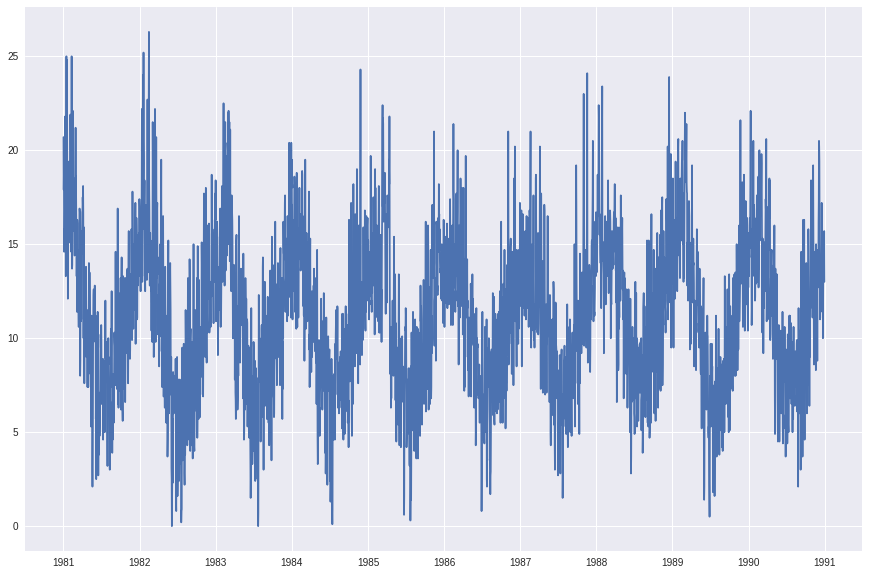

In [45]:
plt.figure(figsize=(15,10))
plt.plot(df['date'], df['temperature'])
plt.show()

### Open with Csv module

In [46]:
time_step = []
temps = []

with open(name_file, 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step = 0
  for row in reader:
    temps.append(float(row[1]))
    time_step.append(step)
    step +=1

series = np.array(temps)
time = np.array(time_step)

### Normalization Function

In [47]:
# DO NOT CHANGE THIS CODE
min=np.min(series)
max=np.max(series)
series -= min
series /= max

### Set Params

In [48]:
# DO NOT CHANGE THIS CODE
window_size=64
batch_size=256
shuffle_buffer_size=1000

split_time=2500

desired_accuracy = 0.19

### Fixed Partition

In [49]:
time_train= time[:split_time]
x_train= series[:split_time]
time_valid= time[split_time:]
x_valid= series[split_time:]

### Windowing Datasets

In [50]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [51]:
train_set=windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>
(2500,)


### Create Custom Callbacks

In [52]:
class MyCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epochs, logs):
            if logs.get('mae') < desired_accuracy:
                print(f'\nTraining MAE was < {desired_accuracy*100}%, stop training...')
                self.model.stop_training = True

custom_callback = MyCallback()

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7 * 10**(epoch / 20))

### Create Model with Learning rate Schedule

In [53]:
def create_model():
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]))
  model.add(tf.keras.layers.LSTM(64, return_sequences=True))
  model.add(tf.keras.layers.LSTM(64, return_sequences=True))
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(1))

  model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=1e-7),
        loss=tf.keras.losses.Huber(),
        metrics=["mae"])
  
  return model

In [54]:
model = create_model()
print(f"Model : {model}")

Model : <keras.engine.sequential.Sequential object at 0x7f2455369690>


In [55]:
hist = model.fit(train_set ,epochs=100, callbacks=[lr_schedule])

Epoch 1/100
10/10 [==============================] - 3s 25ms/step - loss: 0.0977 - mae: 0.4141 - lr: 1.0000e-07
Epoch 2/100
10/10 [==============================] - 0s 29ms/step - loss: 0.0976 - mae: 0.4141 - lr: 1.1220e-07
Epoch 3/100
10/10 [==============================] - 0s 31ms/step - loss: 0.0976 - mae: 0.4140 - lr: 1.2589e-07
Epoch 4/100
10/10 [==============================] - 0s 28ms/step - loss: 0.0976 - mae: 0.4140 - lr: 1.4125e-07
Epoch 5/100
10/10 [==============================] - 0s 30ms/step - loss: 0.0976 - mae: 0.4139 - lr: 1.5849e-07
Epoch 6/100
10/10 [==============================] - 0s 29ms/step - loss: 0.0976 - mae: 0.4139 - lr: 1.7783e-07
Epoch 7/100
10/10 [==============================] - 0s 31ms/step - loss: 0.0975 - mae: 0.4138 - lr: 1.9953e-07
Epoch 8/100
10/10 [==============================] - 0s 30ms/step - loss: 0.0975 - mae: 0.4137 - lr: 2.2387e-07
Epoch 9/100
10/10 [==============================] - 0s 30ms/step - loss: 0.0975 - mae: 0.4136 - lr: 2.5

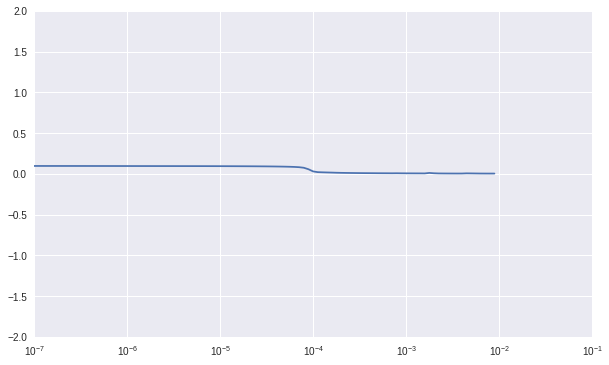

In [56]:
plt.figure(figsize=(10,6))
plt.semilogx(hist.history["lr"], hist.history["loss"])
plt.axis([1e-7, 1e-1, -2, 2])
plt.show()

### Create fixed model

In [57]:
def create_model_fix():
  model = tf.keras.Sequential()

  model.add(tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]))
  model.add(tf.keras.layers.LSTM(64, return_sequences=True))
  model.add(tf.keras.layers.LSTM(64, return_sequences=True))
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(10, activation='relu'))
  model.add(tf.keras.layers.Dense(1))

  model.compile(
        optimizer= tf.keras.optimizers.Adam(learning_rate=1e-1),
        loss=tf.keras.losses.Huber(),
        metrics=["mae"])
  
  return model

In [58]:
model = create_model_fix()
print(f"Model : {model}")

Model : <keras.engine.sequential.Sequential object at 0x7f245690e750>


In [59]:
hist = model.fit(train_set ,epochs=100, callbacks=[custom_callback])

Epoch 1/100
10/10 [==============================] - 4s 26ms/step - loss: 1.4167 - mae: 1.6921
Epoch 2/100
 9/10 [==========================>...] - ETA: 0s - loss: 0.0137 - mae: 0.1323
Training MAE was < 19.0%, stop training...
10/10 [==============================] - 0s 33ms/step - loss: 0.0136 - mae: 0.1316
